**Importing Libraries**

In [1]:
import pickle
import pandas as pd
import numpy as np

from tensorflow import keras
from skimage.io import imread
import skimage.transform as st
from sklearn.cluster import KMeans
from tensorflow.keras.preprocessing import image
from IPython.core.display import display, HTML

import matplotlib.pyplot as plt
import imageio
import cv2

**Loading pre built models**

In [2]:
# Loading RESNet model
model = keras.models.load_model('C:/Users/VideoMachine/IH-labs/art.i/Model/models/RasNet50_v3_f.h5')

# loading clustering model
cluster = pickle.load(open("C:/Users/VideoMachine/IH-labs/art.i/Model/models/model_clustering.sav", 'rb'))

**Function to get painting color pallete**

In [3]:
def get_pallete(image_filename, k=5, target_size = 240):
    
    # turning image rgb ranges to 0-1
    image = np.array(imread(image_filename), dtype=np.float64) / 255
    w, h, d  = image.shape
    
    # calculating ratio of transformation to get to the model requisites, 240px
    if w>h:
        ratio = target_size/h
    else:
        ratio = target_size/w

    # rescaling image based on ratio
    image = st.rescale(image, ratio, channel_axis=2)

    # Reshaping image 
    w, h, d  = image.shape
    image = np.reshape(image, (w * h, d))
    
    # Clustering and returning the centroids, our pallete colors
    clf = KMeans(n_clusters=k)
    clf.fit(image)
    return clf.cluster_centers_

**Function that sugests a painting based on pallete and movement**

In [66]:
def sugest_paintings(palete, movement):
    
    # image bins to recomend
    nd2_rel_path = 'Images/train/'
    nd1_rel_path =  "Images/images_chicago/"
    
    # temporary dataset that mimics the dataset required by the clustering model
    cols = ['c1_r','c1_g','c1_b','c2_r','c2_g','c2_b','c3_r','c3_g','c3_b','c4_r','c4_g','c4_b','c5_r','c5_g','c5_b'] 
    tmp = pd.DataFrame( columns = cols)
    
    # building the dataset
    tmp.loc[len(tmp)] = [item for sublist in palete for item in sublist]
    cluster_painting = cluster.predict(tmp)[0]
    
    # preloading datasets with images that can be recomended
    data1 = pd.read_csv("C:/Users/VideoMachine/IH-labs/art.i/CSV's/clustered/artic_edu_Valid_paintings_pallete_clustered_url.csv")
    data2 = pd.read_csv("C:/Users/VideoMachine/IH-labs/art.i/CSV's/clustered/trainset_color_palletes_clustered_url.csv")
    
    # inicializing number of dataset2 available paintings to 0, doing the same with dataset1(prefered)
    # so it tries to get all the paintings from dataset within spec
    n_d2 = 0
    n_d1 = len(data1[(data1['style'] == movement) & (data1['color_cluster'] == cluster_painting)])  
    
    # Test if our museum db(dataset1) has any matches, if it doesent have enough we will complement with 
    # dataset2(wikiart)
    if n_d1<3:
        n_d2 = 3 - n_d1 
    
    links = []
    lst_path = []
    labels = []
    artists = []
    
    # Apending images url and path of all sugestions
    if n_d1 !=0:
        tmp = data1[(data1['style'] == movement) & (data1['color_cluster'] == cluster_painting)].sample(n_d1)
        for i in range(n_d1):
            lst_path.append(nd1_rel_path+tmp.id.iloc[i]+'.jpg')
            links.append(tmp.wiki_url.iloc[i])
            labels.append(tmp.title.iloc[i]+' '+str(round(tmp.year.iloc[i])))
            artists.append(tmp.artiste.iloc[i])
            
            
    if n_d2 !=0:
        tmp2 = data2[(data2['style'] == movement) & (data2['color_cluster'] == cluster_painting)].sample(n_d2)
        for i in range(3-n_d1):
            lst_path.append(nd2_rel_path+tmp2.id.iloc[i])
            links.append(tmp2.wiki_url.iloc[i])
            labels.append(tmp2.wiki_url.iloc[i].split('/')[-1].replace('-', ' ').title())
            artists.append(tmp2.artiste.iloc[i])
    
    # ploting images previously selected
    figure, axis = plt.subplots(1, 3,figsize=(15, 5))
    axis[0].imshow(imageio.imread(lst_path[0]))
    axis[0].axis('off')
    axis[0].set_title(artists[0])
    axis[1].imshow(imageio.imread(lst_path[1]))
    axis[1].axis('off')
    axis[1].set_title(artists[1])
    axis[2].imshow(imageio.imread(lst_path[2]))    
    axis[2].axis('off')
    axis[2].set_title(artists[2])
    
    # printing links
    print('\nFor more detailed info follow the links')
    for i in range(3):
        x="""<a href="""+links[i]+'>'+labels[i]+'</a>'
        display(HTML(x))

In [5]:
# Movements by id
key  = { 0 : 'Abstract Expressionism',
         1 : 'Art Nouveau (Modern)',
         2 : 'Baroque + Rococo',
         3 : 'Cubism',
         4 : 'Expressionism',
         5 : 'Impressionism',
         6 : 'Naïve Art (Primitivism)',
         7 : 'Neoclassicism',
         8 : 'Northern Renaissance',
         9 : 'Romanticism + Realism',
         10 : 'Surrealism',
         11 : 'Symbolism'}

**Main Predictive Function**


Sugested Paintings for Impressionism with 92 % probability

For more detailed info follow the links


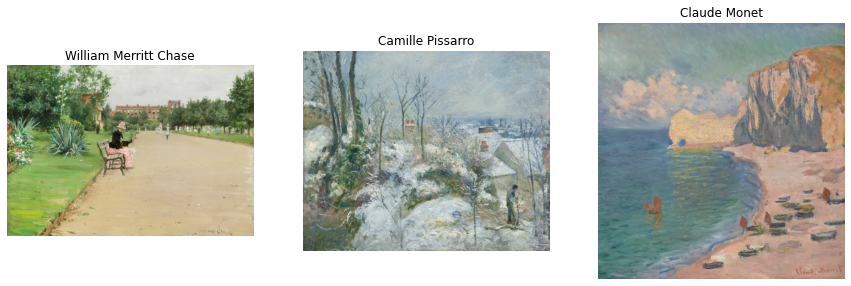

In [67]:
# path of file to predict
path = 'C:/Users/VideoMachine/IH-labs/art.i/Model/Images/Impressionism/12777.jpg'

# converting image to the correct shape that the model requires
img = imageio.imread(path)
img = cv2.resize(img, dsize=(224,224)[0:2], )
img = image.img_to_array(img)
img /= 255.
img = np.expand_dims(img, axis=0)

# predicting movement
prediction = model.predict(img, verbose = 0)

# Sugesting Paintings
print('\nSugested Paintings for', key[np.argmax(prediction)], 'with', round(np.amax(prediction)*100), "% probability")  
sugest_paintings(get_pallete(path), key[np.argmax(prediction)])